In [1]:
import pandas

In [14]:
laned_data = pandas.read_csv('5270Sapp.csv', parse_dates=['Time_AEST'])
laned_data

,Time_AEST,Detector_ID,Volume,Occupancy,Speed
0,2021-05-01 00:00:00,5270-VD01,1,0.4,79.0
1,2021-05-01 00:01:00,5270-VD01,0,0.0,NaN
2,2021-05-01 00:02:00,5270-VD01,0,0.0,NaN
3,2021-05-01 00:03:00,5270-VD01,1,0.3,100.0
4,2021-05-01 00:04:00,5270-VD01,0,0.1,NaN
...,...,...,...,...,...
351015,2021-06-30 23:55:00,5270-VD07,0,0.0,NaN
351016,2021-06-30 23:56:00,5270-VD07,1,0.4,100.0
351017,2021-06-30 23:57:00,5270-VD07,0,0.0,NaN
351018,2021-06-30 23:58:00,5270-VD07,0,0.0,NaN


In [3]:
detector_list = laned_data['Detector_ID'].unique()

In [4]:
import math

def harmonic_mean_speed(group) :
    denominator = (group.Volume / group.Speed).sum()
    if denominator :
        return group.Volume.sum() / denominator
    else :
        return math.nan

## Determine volume weighted harmonic mean speed for each lane (detector)

In [5]:
laned_data.groupby('Detector_ID').apply(harmonic_mean_speed)

Detector_ID
5270-VD01    55.796389
5270-VD03    74.248648
5270-VD05    85.463897
5270-VD07    85.807204
dtype: float64

## Combine lanes into one row for each time point

In [6]:
def combine_lanes(group) :
    return pandas.Series([group.Volume.mean(), group.Occupancy.mean(), harmonic_mean_speed(group)], index=['Volume', 'Occupancy', 'Speed'])

combined_lanes = laned_data.groupby('Time_AEST').apply(combine_lanes)

# Analyse 2nd Week (2021-05-10 to 2021-05-16)

In [7]:
week2 = combined_lanes['2021-05-10':'2021-05-16']
week2

,Volume,Occupancy,Speed
Time_AEST,,,
2021-05-10 00:00:00,0.75,0.300,90.978261
2021-05-10 00:01:00,1.00,0.375,97.407692
2021-05-10 00:02:00,2.25,1.075,93.382488
2021-05-10 00:03:00,0.50,0.200,93.000000
2021-05-10 00:04:00,1.25,0.425,95.647773
...,...,...,...
2021-05-16 23:55:00,1.00,0.375,97.224558
2021-05-16 23:56:00,2.00,0.750,101.120473
2021-05-16 23:57:00,1.75,0.775,96.142772


In [8]:
def plotByTime(data, column, units) :
    plot = data[column].plot(figsize=(25,8))
    plot.set_title(f'Combined {column} vs Date time (for week 2)')
    plot.set_ylabel(f"{column} ({units})")
    plot.set_xlabel('Date time (AEST)')  

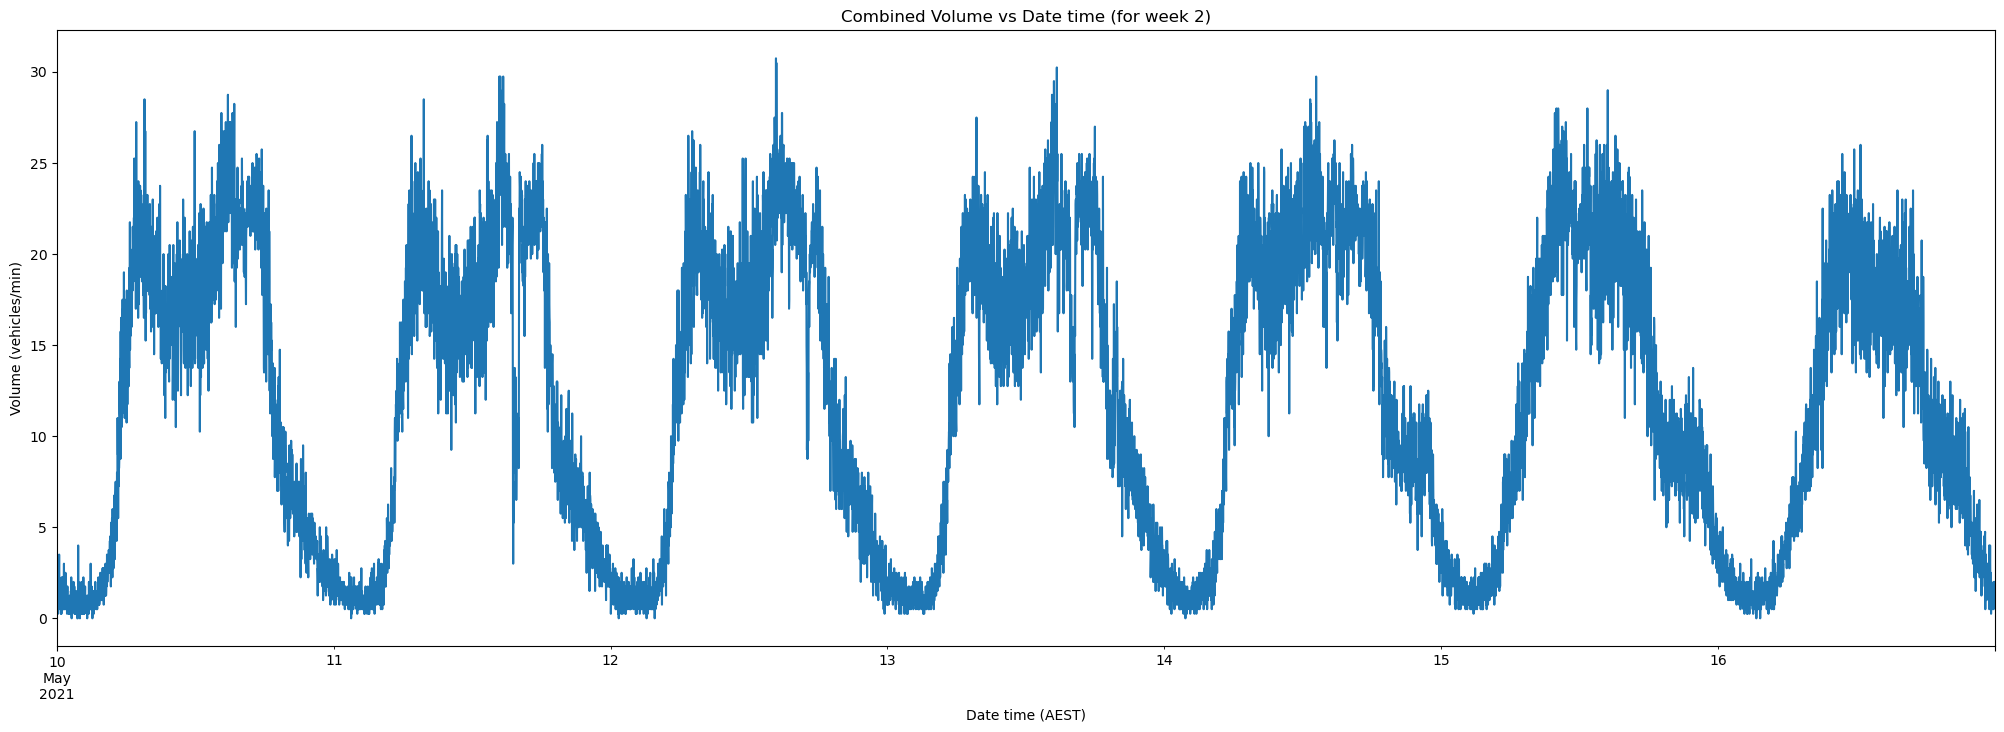

In [9]:
plotByTime(week2, 'Volume', 'vehicles/min')

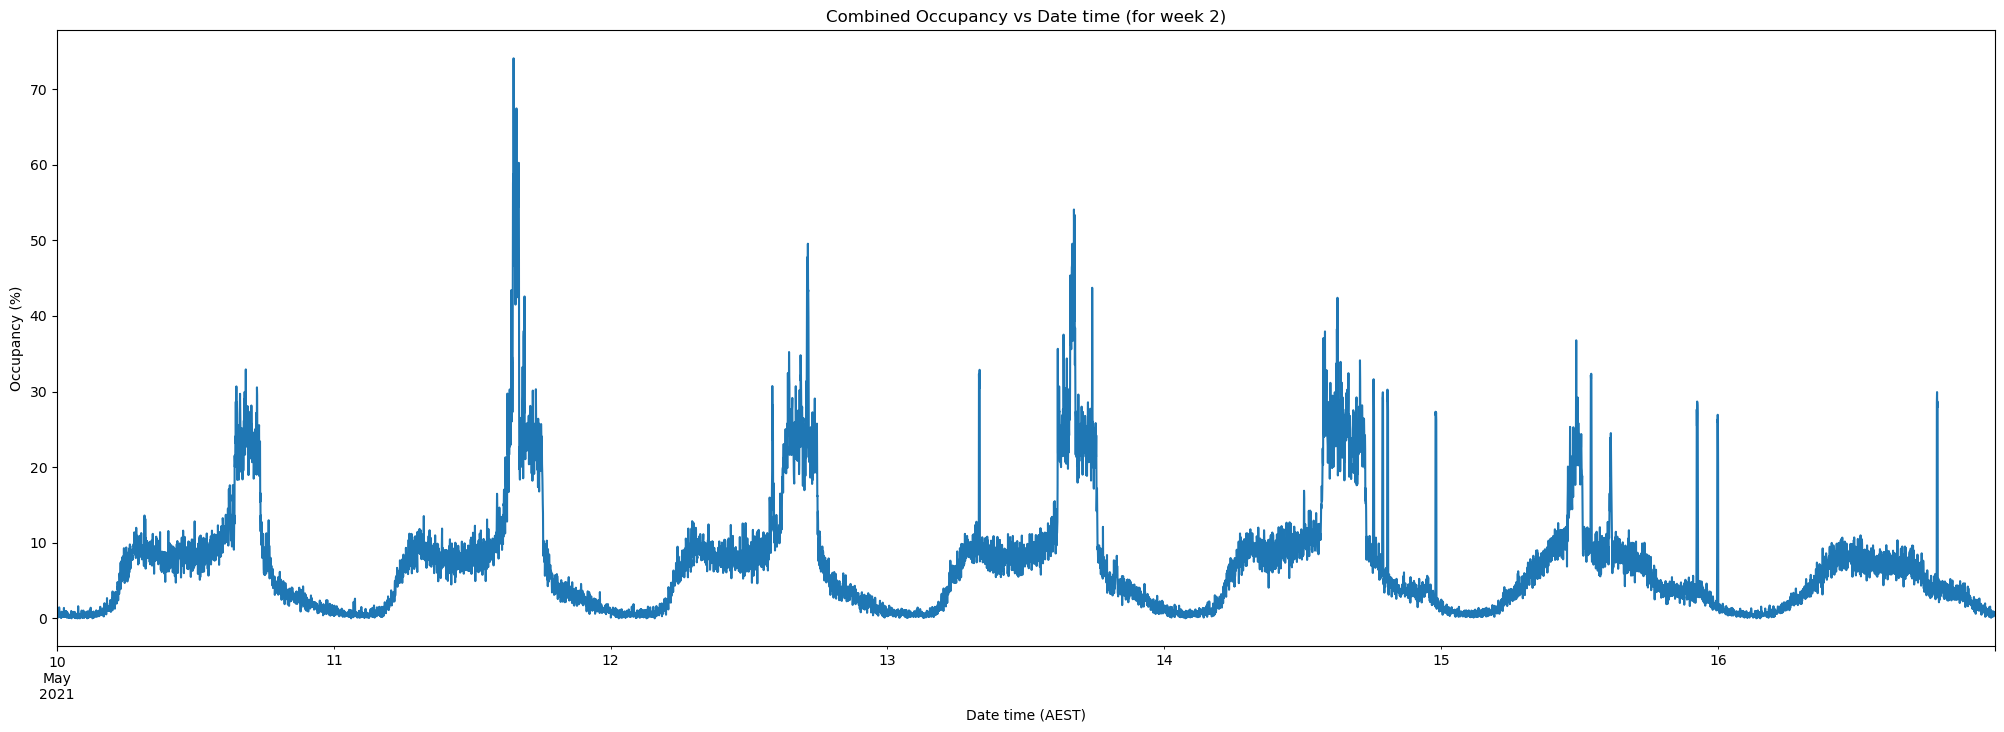

In [10]:
plotByTime(week2, 'Occupancy', '%')

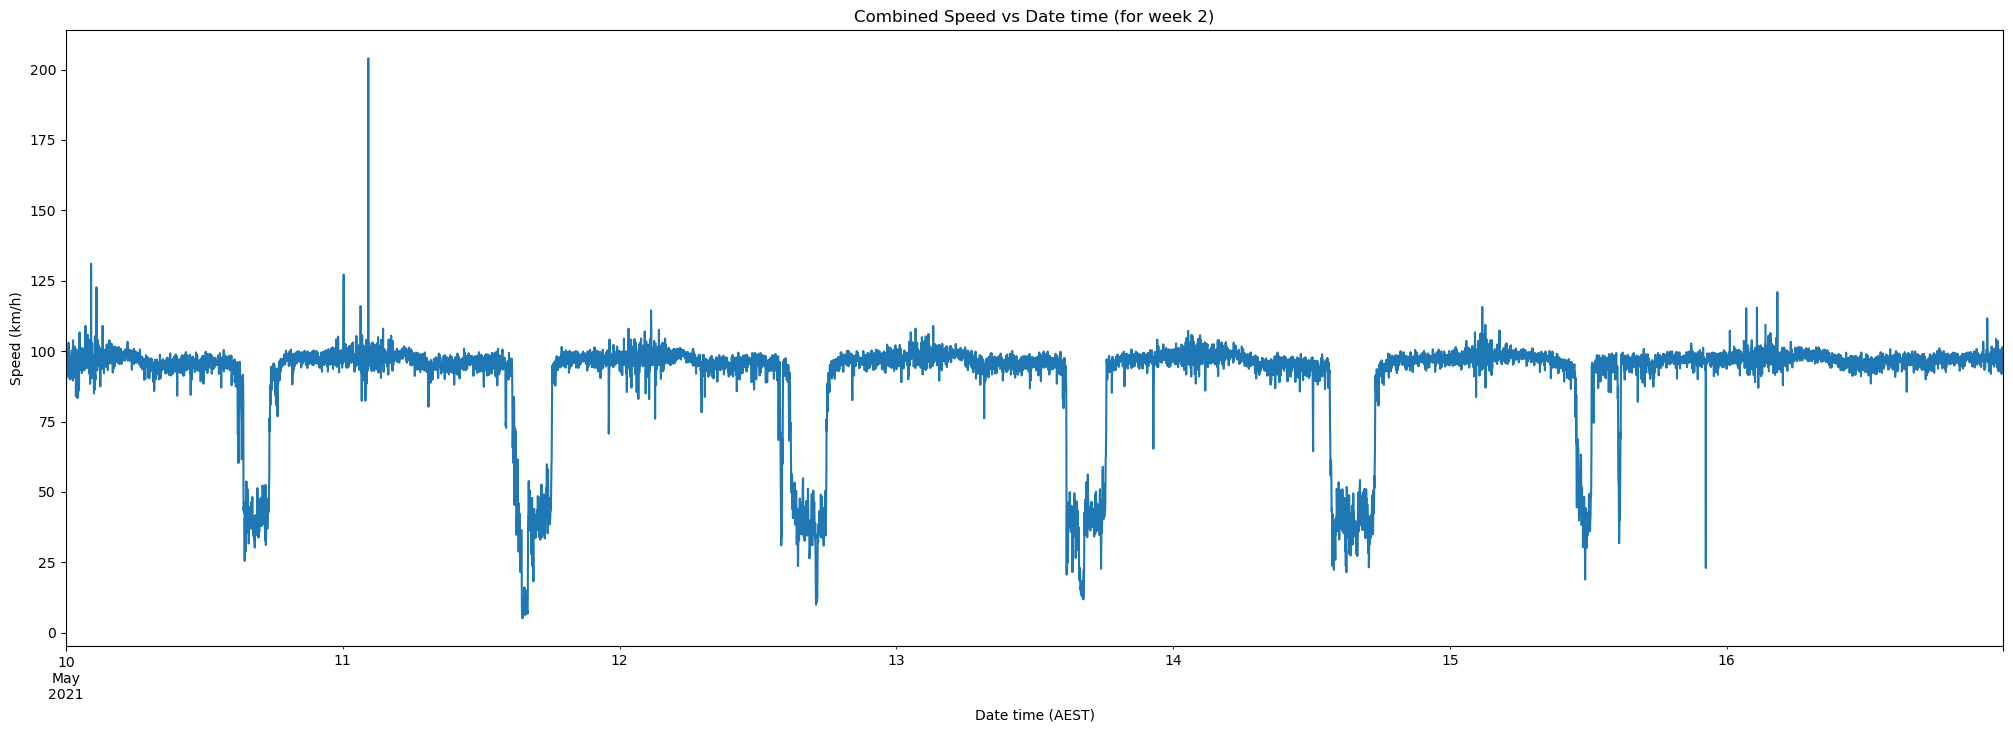

In [11]:
plotByTime(week2, 'Speed', 'km/h')

# Analyse by Day of week

In [12]:
def plot_by_day(column, units) :
    combined_lanes['day'] = combined_lanes.index.day_of_week    
    day_labels = ['', 'Mon','Tue', 'Wed','Thu','Fri','Sat','Sun']
    plot = combined_lanes.boxplot(column=column, by='day', figsize=(25,8), grid=False, showfliers=False)
    print(type(plot))
    plot.set_ylabel(f'{column} ({units})')
    plot.set_xlabel('Day of week') 
    p = plot.set_xticks(range(0,len(day_labels)), day_labels)    

<class 'matplotlib.axes._subplots.AxesSubplot'>


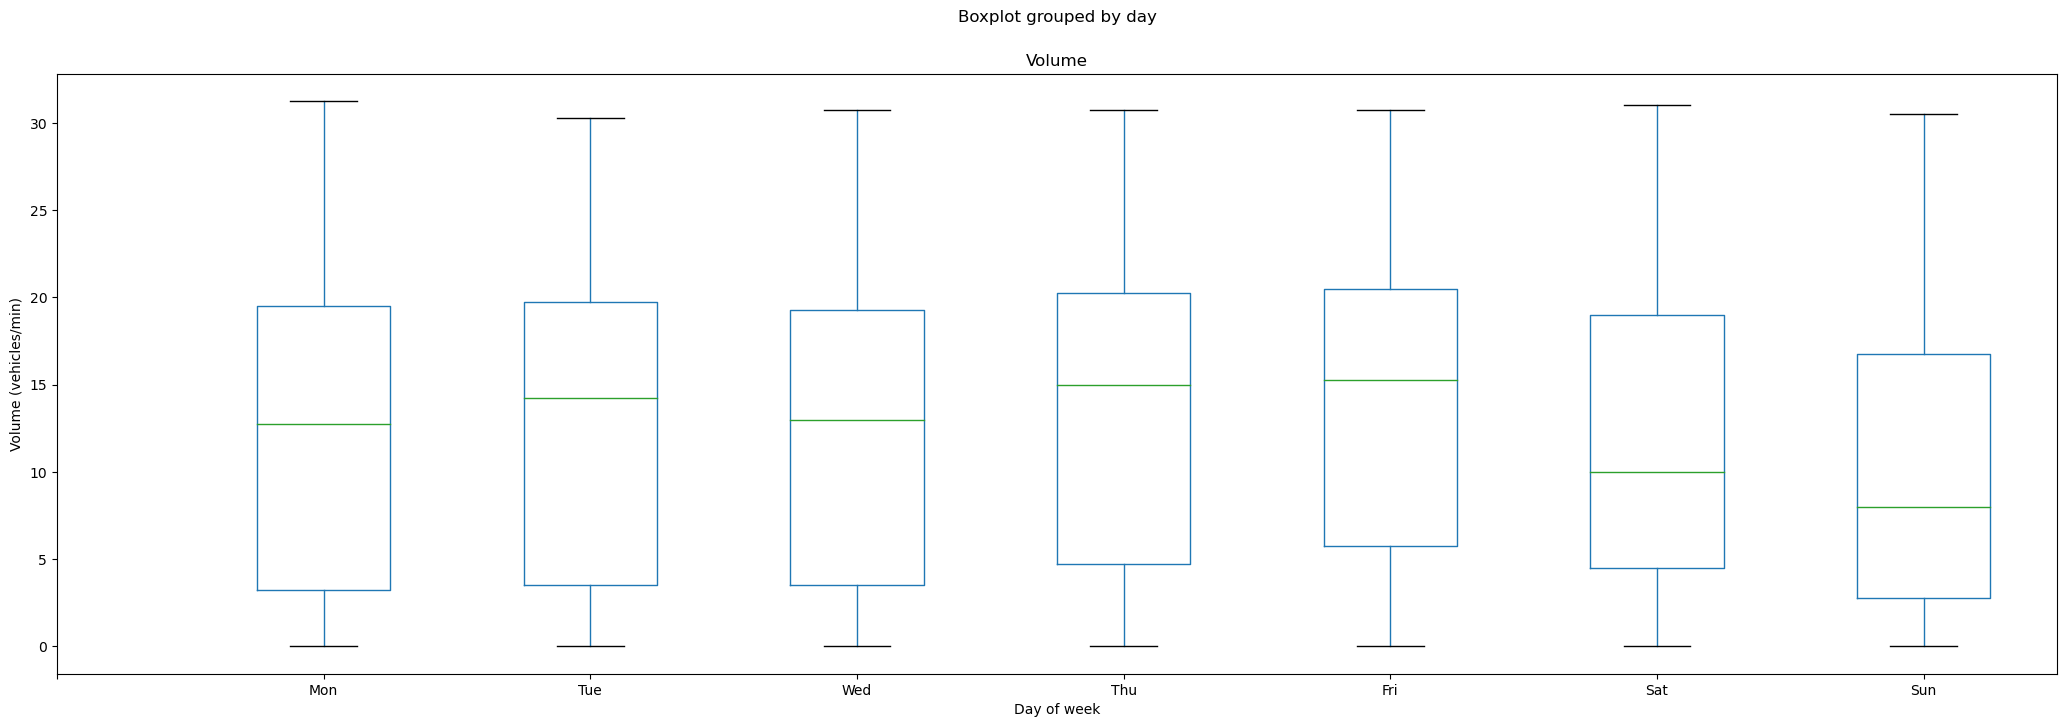

In [13]:
plot_by_day('Volume', 'vehicles/min')

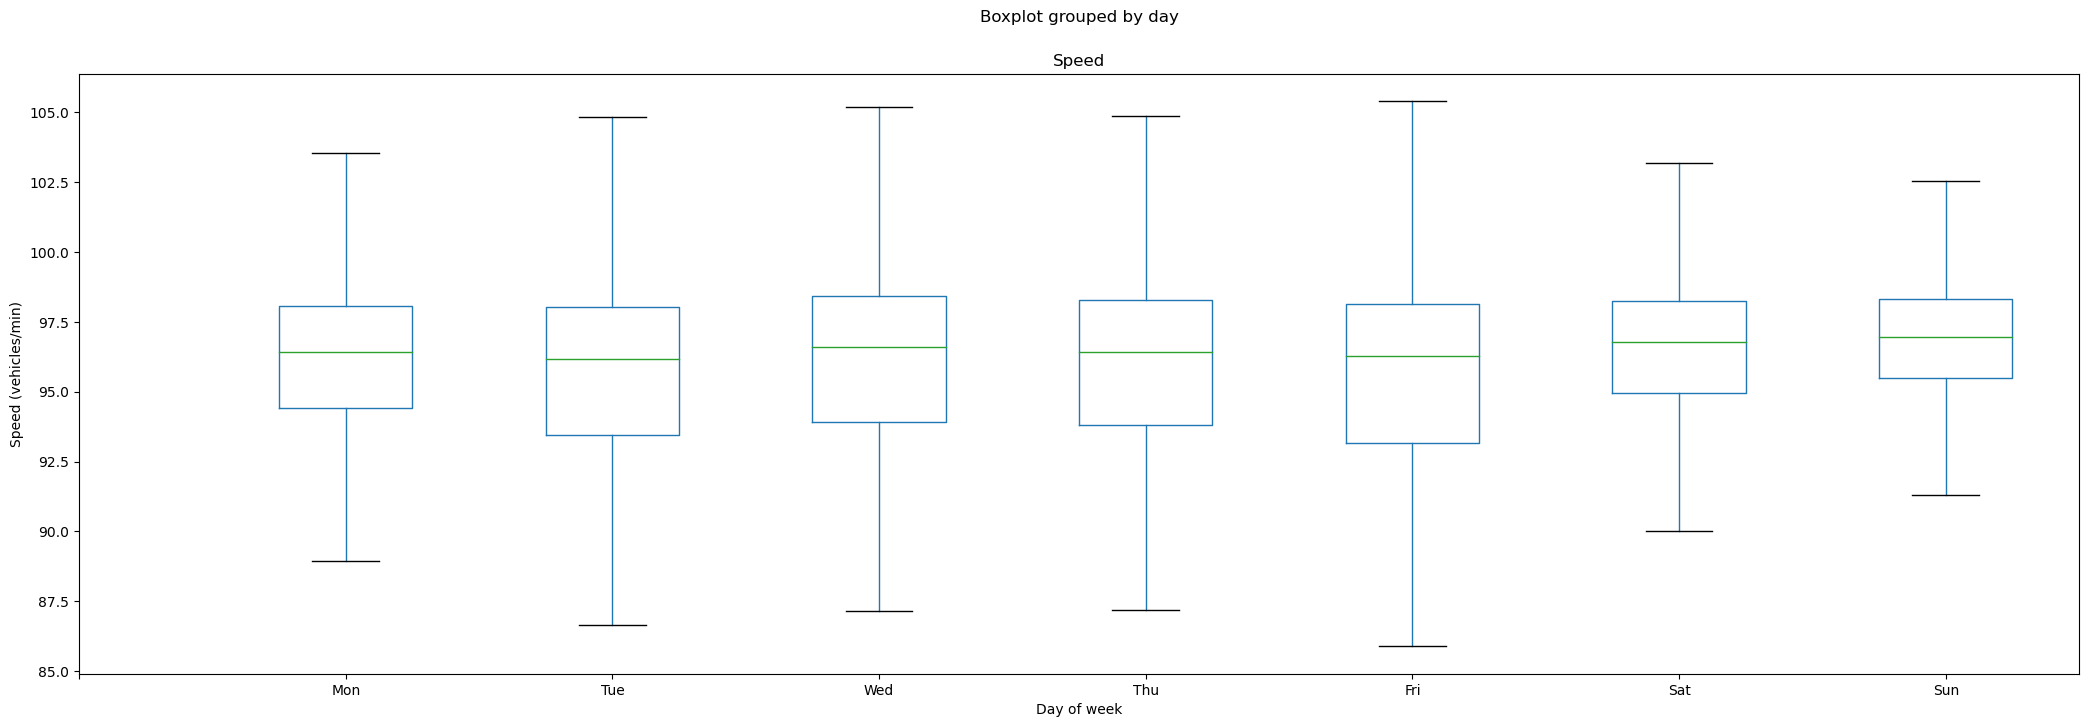

In [16]:
plot_by_day('Speed', 'vehicles/min')

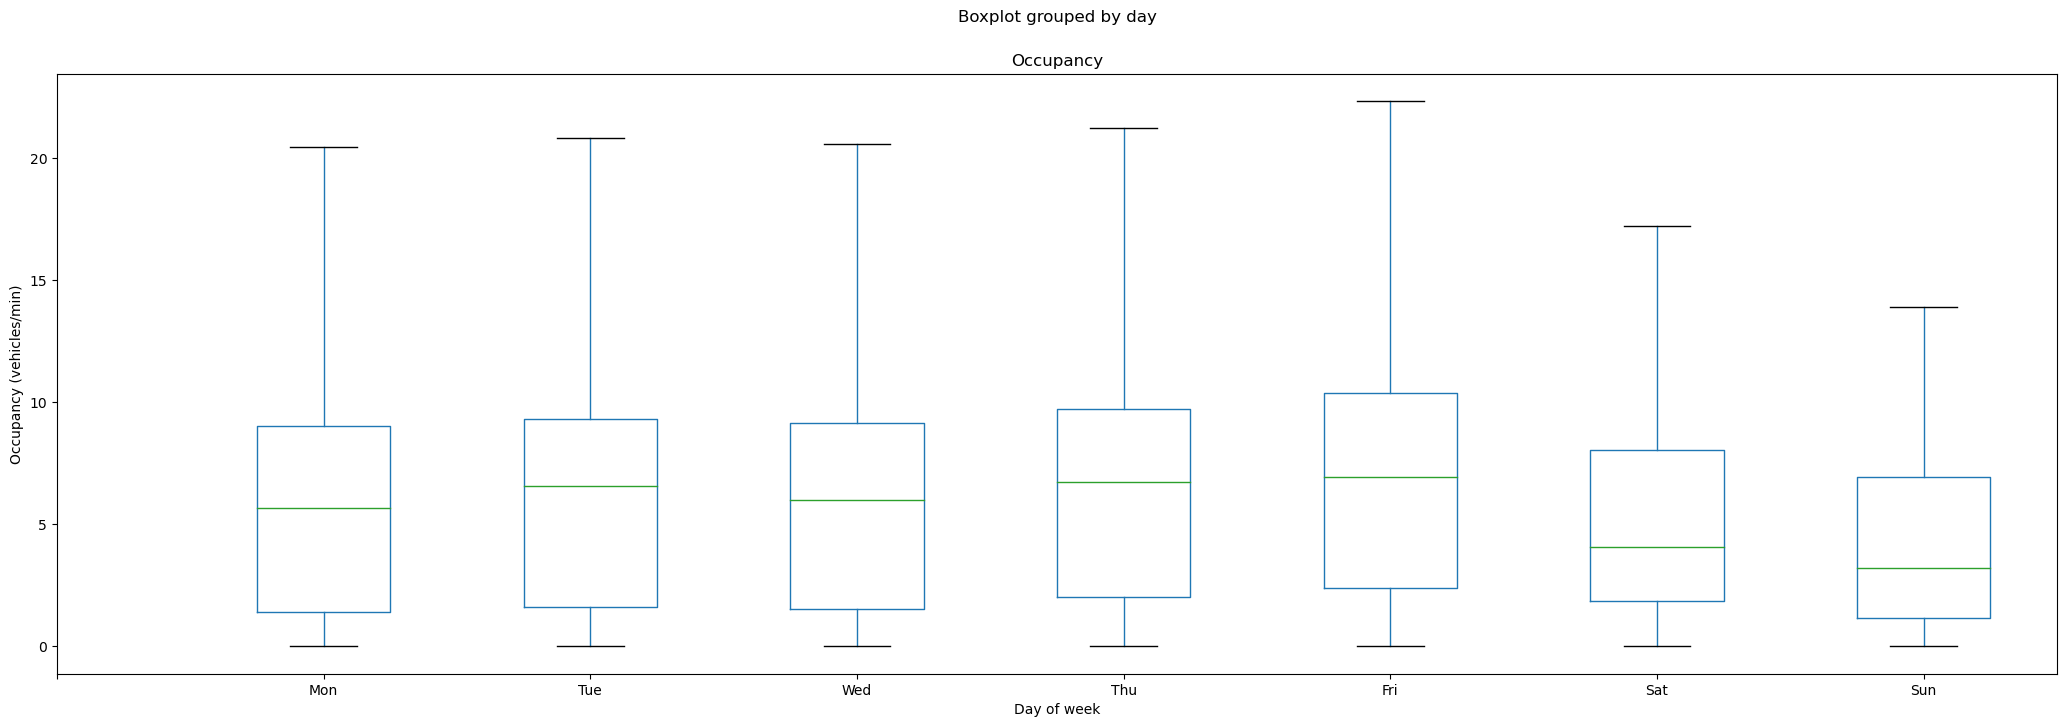

In [17]:
plot_by_day('Occupancy', 'vehicles/min')

# Analyse by Hour of day

In [17]:
def plot_by_hour(column, units, func) :
    day_labels = ['Mon','Tue', 'Wed','Thu','Fri','Sat','Sun']

    func(combined_lanes.groupby([combined_lanes.index.hour])).plot(figsize=(25,8), label='Combined', linewidth=5)

    for day in range(0,7) :
        laned_data_day = laned_data[laned_data.Time_AEST.dt.dayofweek == day]
        plot = func(laned_data_day.groupby(laned_data_day.Time_AEST.dt.hour)).plot(label=day_labels[day])
    
    plot.set_title(f'{column} vs Hour of day')
    plot.set_xticks(range(0,24))
    plot.set_ylabel(f'{column} ({units})')
    plot.set_xlabel('Hour of day')  
    plot.legend()

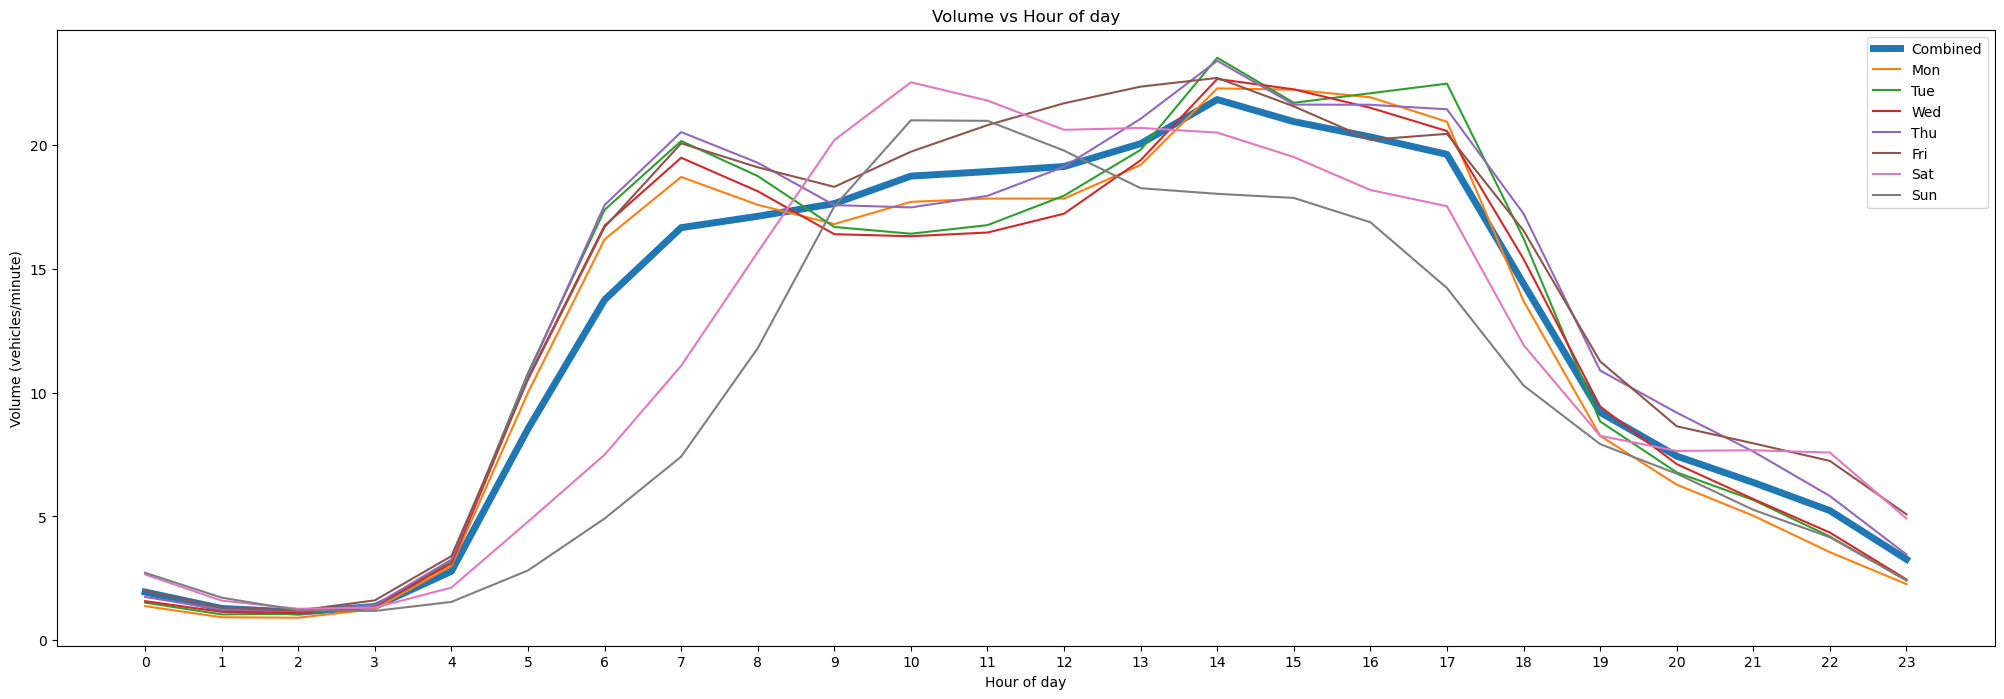

In [18]:
plot_by_hour('Volume', 'vehicles/minute', lambda data: data.Volume.mean())

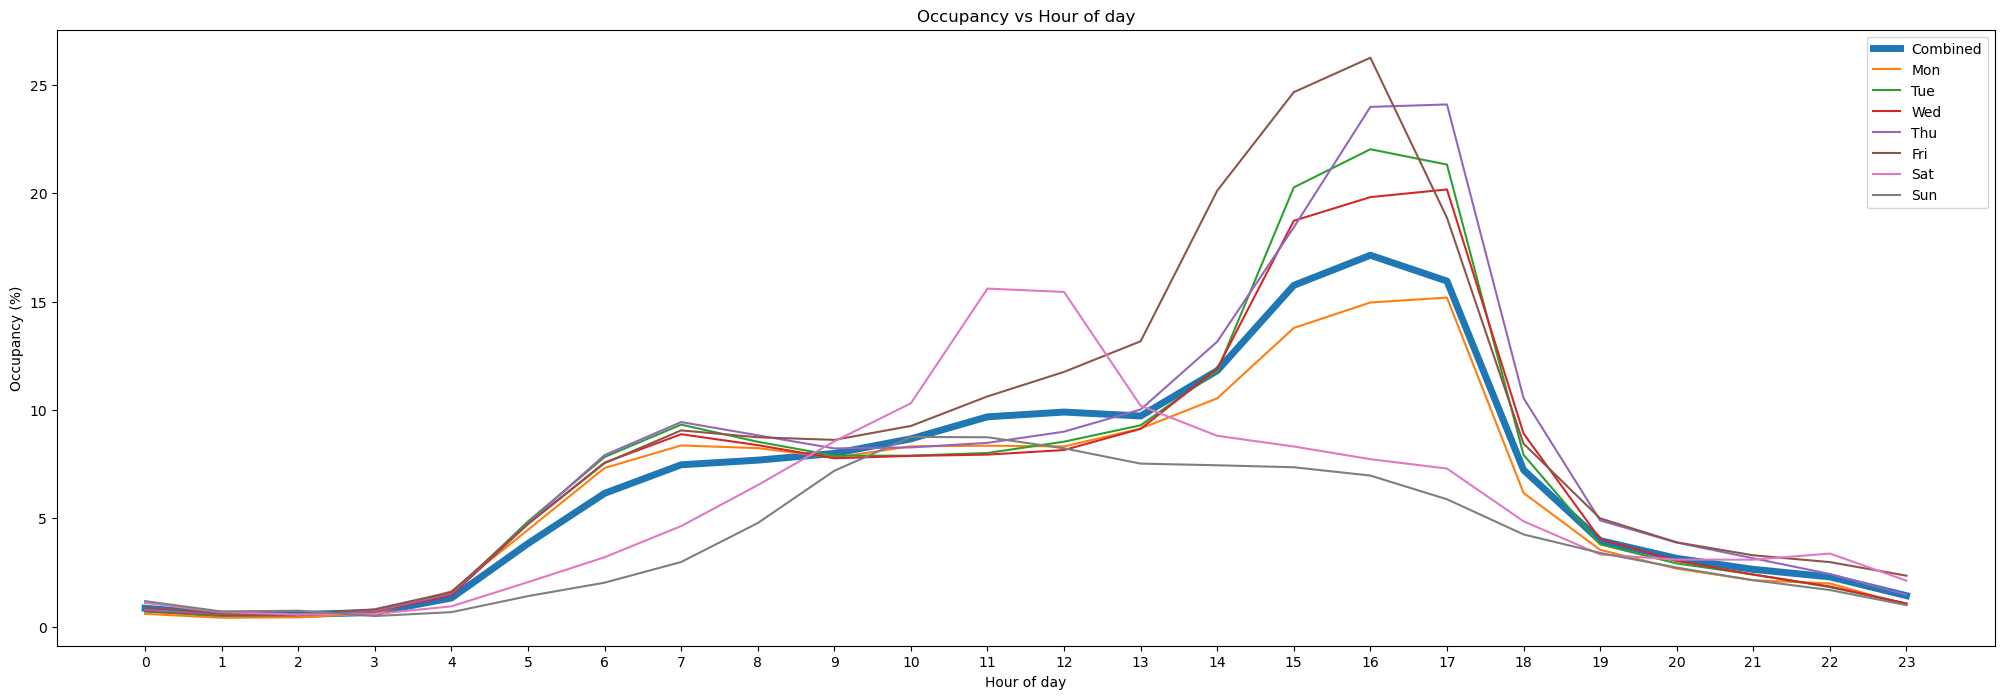

In [19]:
plot_by_hour('Occupancy', '%', lambda data: data.Occupancy.mean())

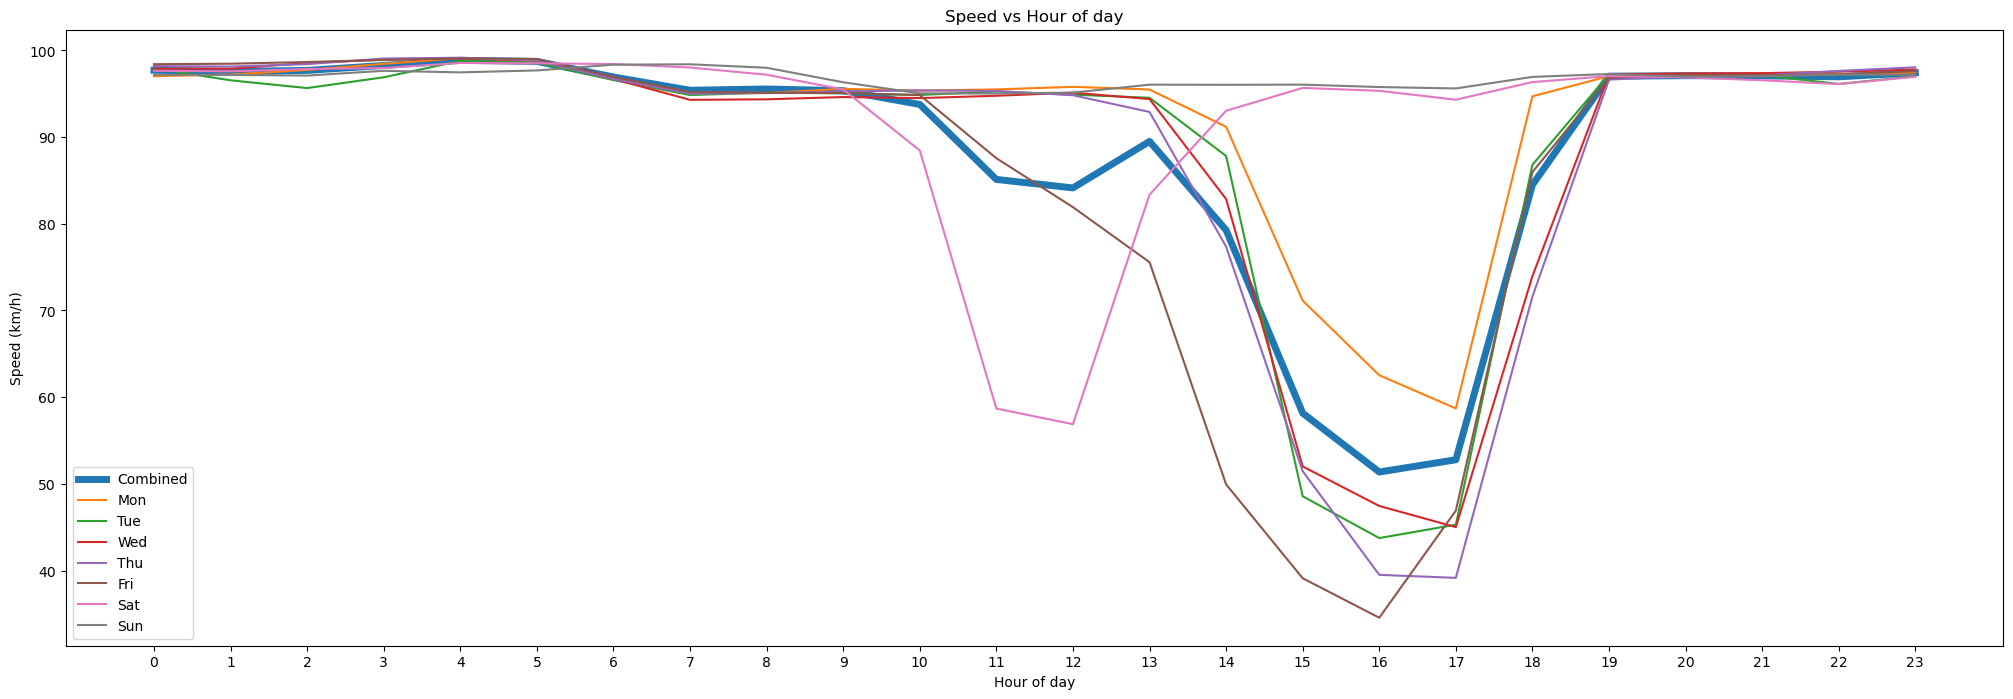

In [20]:
plot_by_hour('Speed', 'km/h', lambda data: data.apply(harmonic_mean_speed))

# Analyse relationship between variables

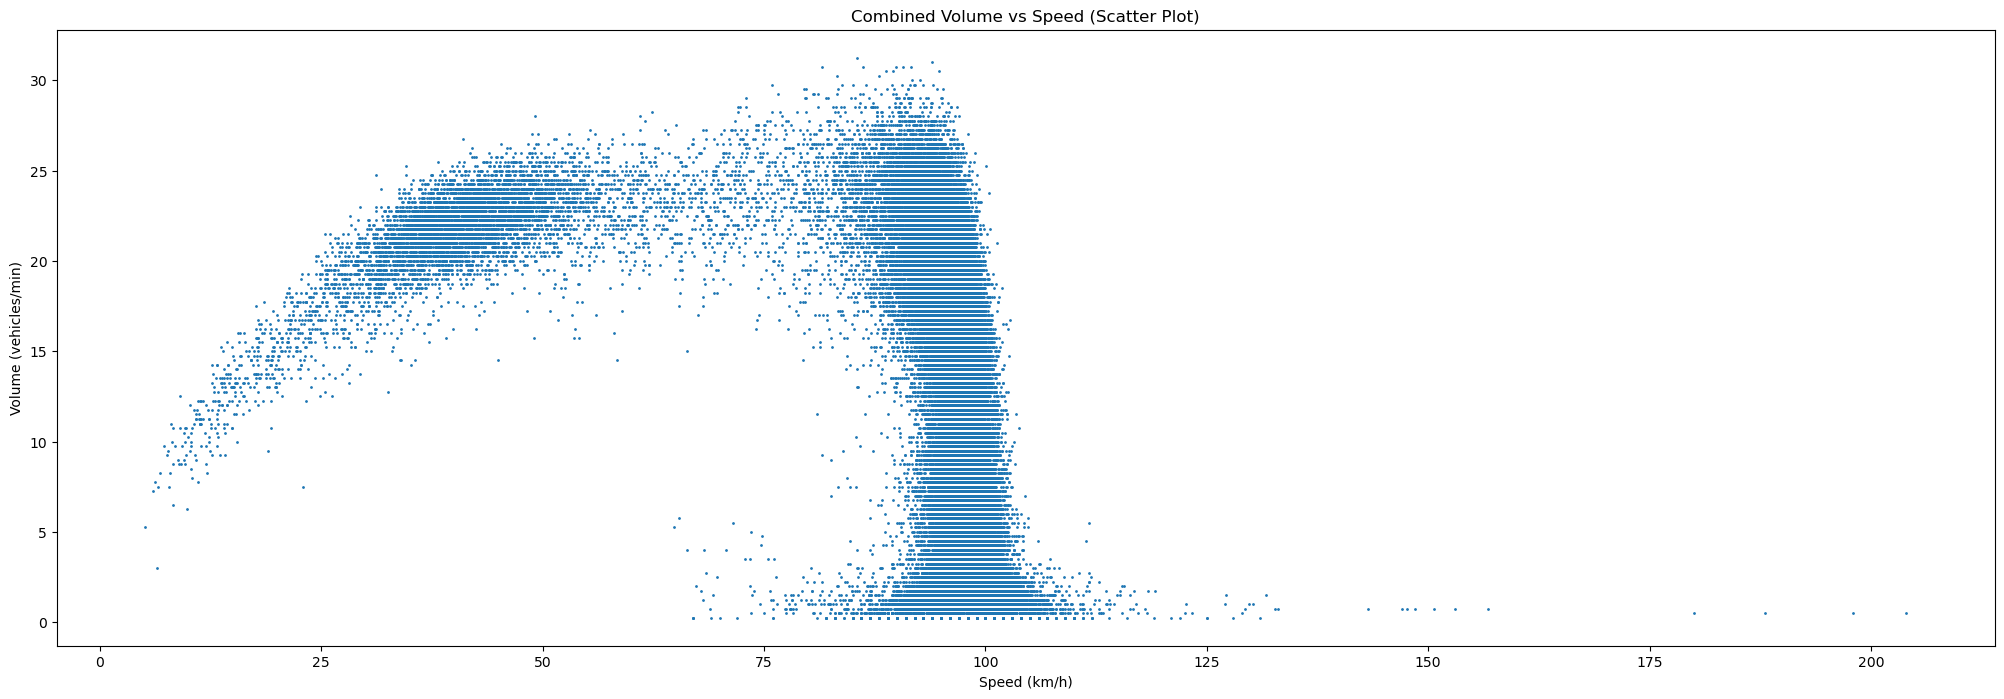

In [21]:
plot = combined_lanes.plot.scatter(x='Speed', y = 'Volume', figsize=(25,8), s = 1)
plot.set_title('Combined Volume vs Speed (Scatter Plot)')
plot.set_ylabel('Volume (vehicles/min)')
p = plot.set_xlabel('Speed (km/h)')

In [22]:
def plot_variable_vs_variable_by_detector(x, xunits, y, yunits, func, r) :
    func(combined_lanes.groupby(pandas.cut(combined_lanes[x], r))).plot(figsize=(25,8), label='Combined', linewidth=5)
    for detector in detector_list:
        data = func(laned_data[laned_data.Detector_ID == detector].groupby(pandas.cut(laned_data[x], r)))
        plot = data.plot(label=detector)
    plot.set_xticks(ticks=range(len(data.index)), labels=data.index, rotation=90)
    plot.set_title(f'{y} vs {x}')
    plot.set_ylabel(f'{y} ({yunits})')
    plot.set_xlabel(f'{x} ({xunits})')
    plot.legend();

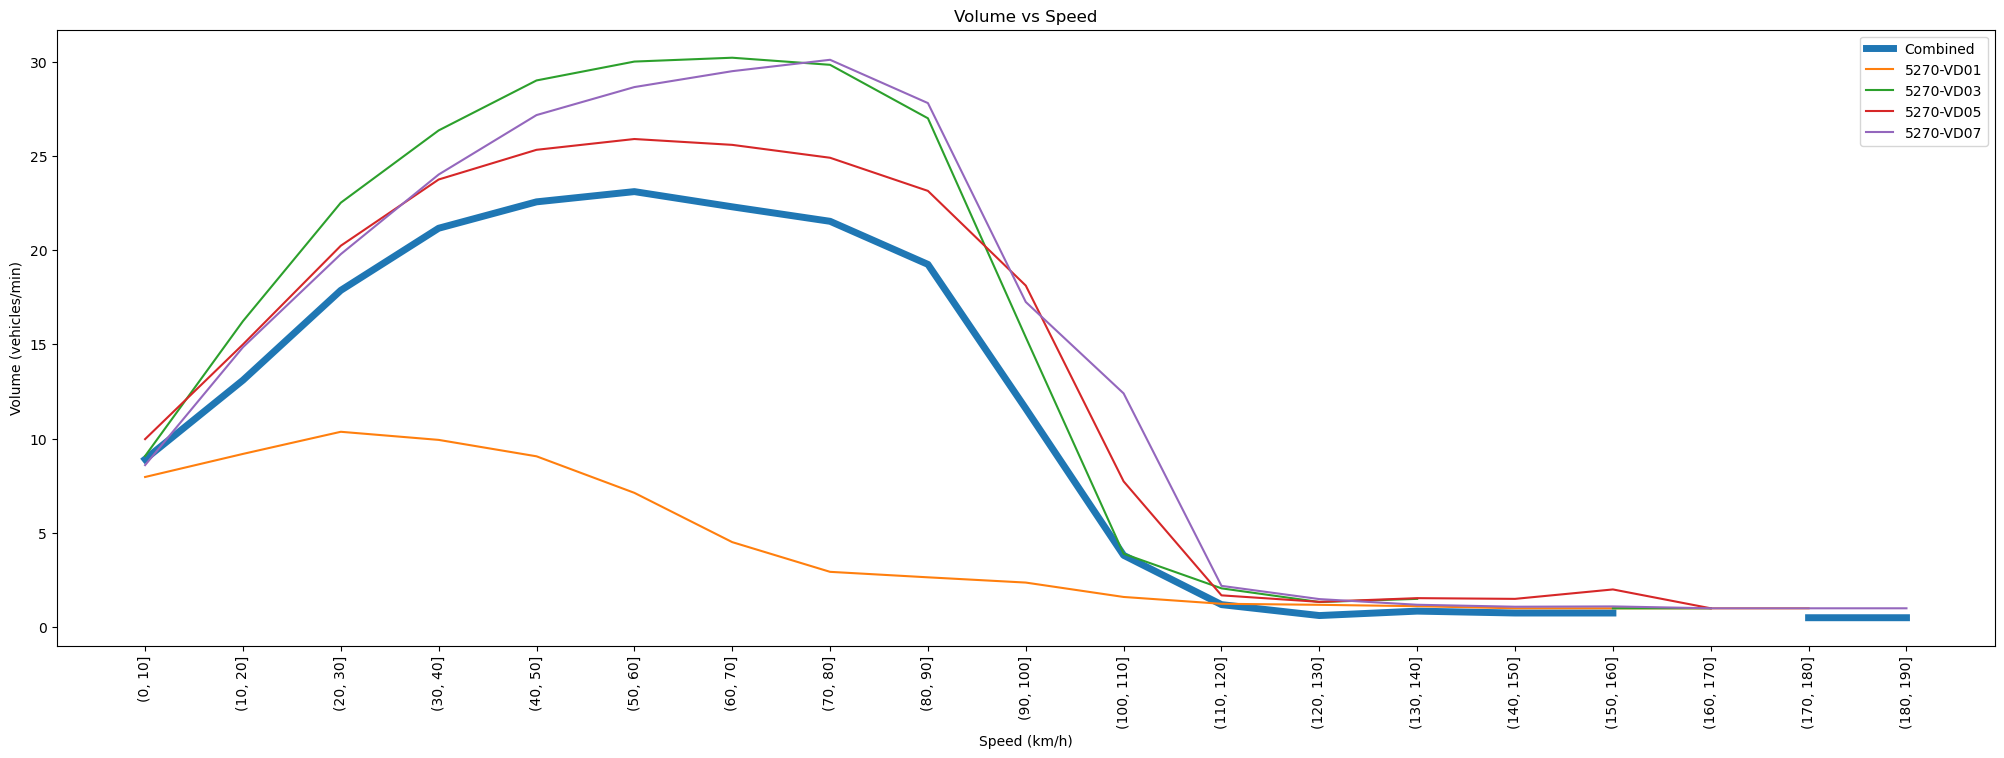

In [23]:
plot_variable_vs_variable_by_detector('Speed', 'km/h', 'Volume', 'vehicles/min', (lambda data: data.Volume.mean()), range(0, 200, 10))

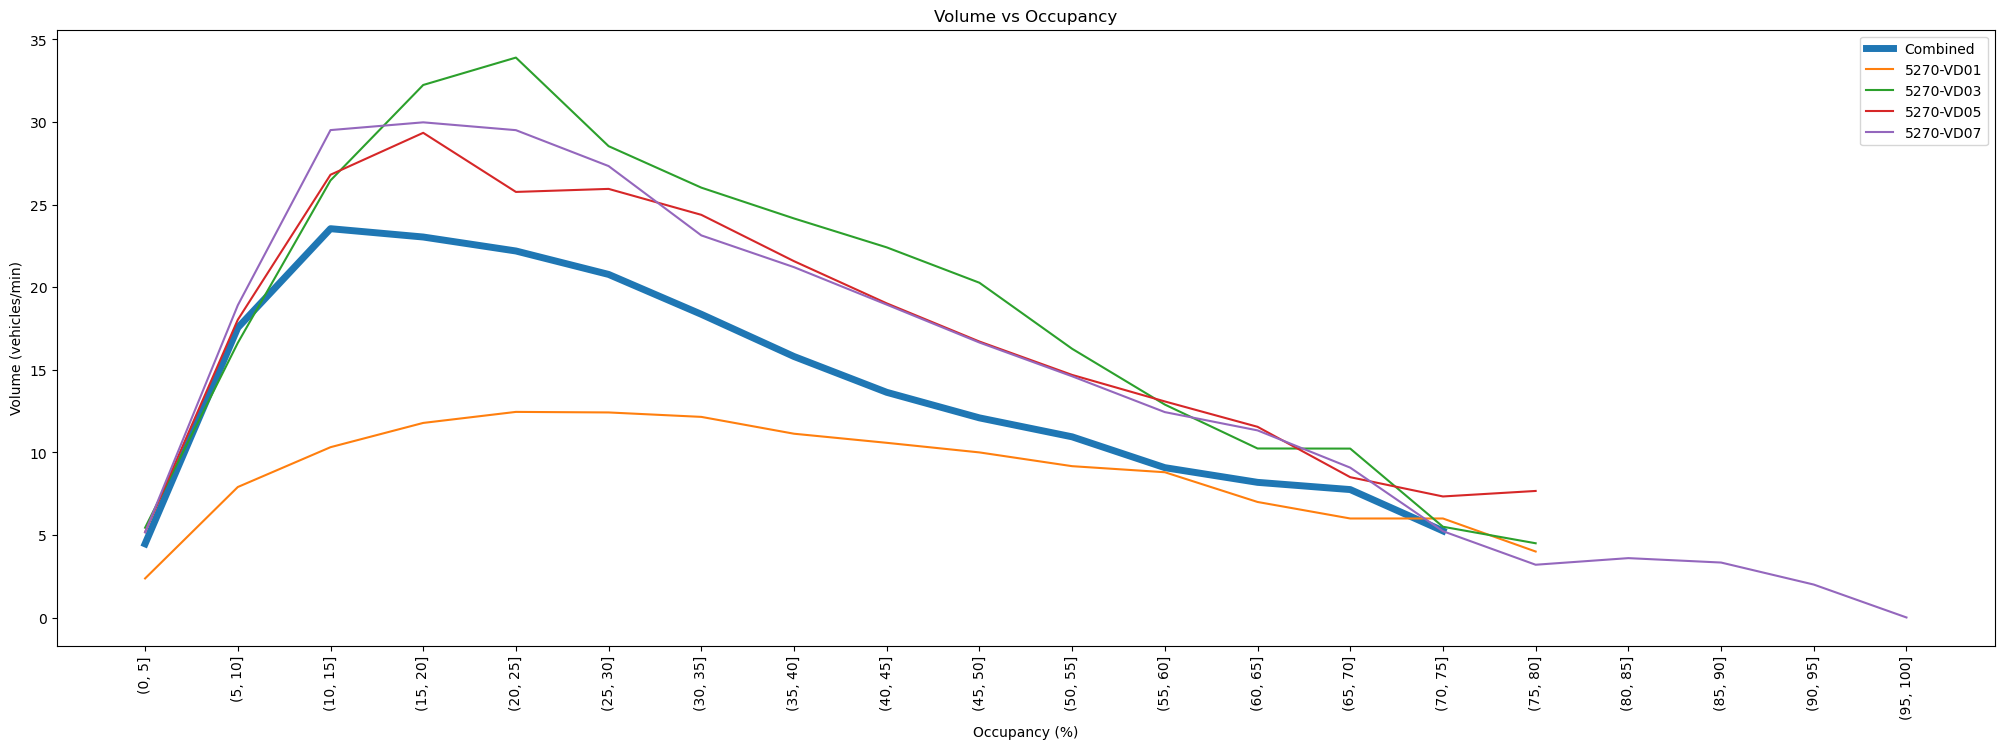

In [24]:
plot_variable_vs_variable_by_detector('Occupancy', '%', 'Volume', 'vehicles/min', (lambda data: data.Volume.mean()), range(0, 101, 5))

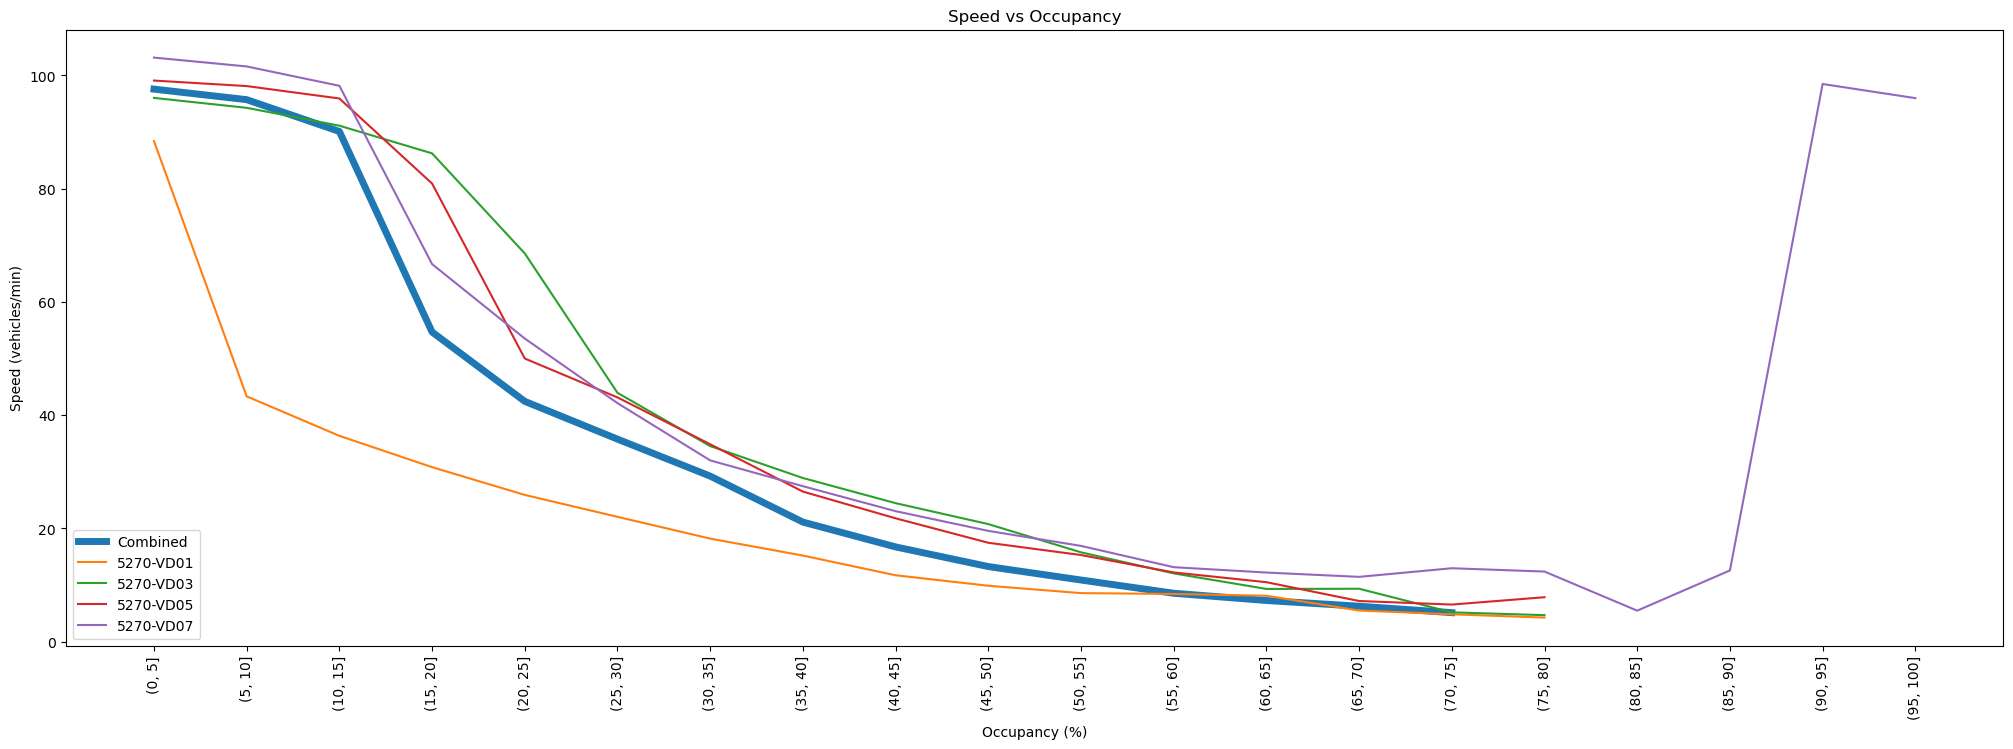

In [25]:
plot_variable_vs_variable_by_detector('Occupancy', '%', 'Speed', 'vehicles/min', (lambda data: data.apply(harmonic_mean_speed)), range(0, 101, 5))